# Tarea: Modelos lineales, regularización y selección de modelos en datos reales

Importamos las librerias necesaria 

In [225]:
#Reseteamos el entorno
%reset -f 


In [227]:
#importamos las librerias necesarias
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline

## Parte A: Parte A. Regresión lineal desde cero


1. Usando LinearRegression de sklearn

In [228]:
# Paso 2: Cargamos el dataset
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target.values
data.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [229]:
# Paso 3: Creamos el conjunto de entrenamiento y prueba
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [230]:
# Paso 4: Estandarizamos características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [231]:
# 4. Ajustar modelo de sklearn
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [232]:
# 5. Predicciones
y_pred = linreg.predict(X_test_scaled)
print("R2 sklearn:", r2_score(y_test, y_pred))
print("MSE sklearn:", mean_squared_error(y_test, y_pred))

R2 sklearn: 0.5757877060324508
MSE sklearn: 0.5558915986952444


In [233]:
# 6. Métricas
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Intercepto (sklearn):", linreg.intercept_)
print("Coeficientes (sklearn):", linreg.coef_)
print("R² (sklearn):", r2)
print("MSE (sklearn):", mse)

Intercepto (sklearn): 2.0719469373788777
Coeficientes (sklearn): [ 0.85438303  0.12254624 -0.29441013  0.33925949 -0.00230772 -0.0408291
 -0.89692888 -0.86984178]
R² (sklearn): 0.5757877060324508
MSE (sklearn): 0.5558915986952444


2. MCO de forma cerrada (Closed-form OLS con NumPy)

In [234]:
# Asegúrate de tener X_train_scaled, X_test_scaled e incluir columna de 1s para el intercepto manual
X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train_scaled]
X_test_bias  = np.c_[np.ones((X_test.shape[0], 1)),  X_test_scaled]

In [235]:
# Fórmula β = (XᵀX)^(-1) Xᵀy
beta_hat = np.linalg.inv(X_train_bias.T @ X_train_bias) @ (X_train_bias.T @ y_train)

intercept_ols = beta_hat[0]
coef_ols = beta_hat[1:]
y_pred_ols = X_test_bias @ beta_hat

print("Intercepto OLS:", intercept_ols)
print("Coeficientes OLS:", coef_ols)
print("R2 OLS:", r2_score(y_test, y_pred_ols))


Intercepto OLS: 2.071946937378877
Coeficientes OLS: [ 0.85438303  0.12254624 -0.29441013  0.33925949 -0.00230772 -0.0408291
 -0.89692888 -0.86984178]
R2 OLS: 0.5757877060324512


In [236]:

# Beta por forma cerrada con pseudoinversa
beta_hat = np.linalg.pinv(X_train_bias.T @ X_train_bias) @ (X_train_bias.T @ y_train)
intercept_ols_manual = beta_hat[0]
coef_ols_manual = beta_hat[1:]

In [237]:
# Predicción y métricas en test
y_pred_ols_manual = X_test_bias @ beta_hat
r2_ols = r2_score(y_test, y_pred_ols_manual)
mse_ols = mean_squared_error(y_test, y_pred_ols_manual)

print(f"OLS (manual) — Intercepto: {intercept_ols_manual:.6f}")
print(f"OLS (manual) — R2 test: {r2_ols:.4f} | MSE test: {mse_ols:.4f}")

OLS (manual) — Intercepto: 2.071947
OLS (manual) — R2 test: 0.5758 | MSE test: 0.5559


In [238]:
# Verificación contra sklearn LinearRegression
lin = LinearRegression(fit_intercept=True)
lin.fit(X_train_scaled, y_train)
print("\nComparación con sklearn.LinearRegression")
print("Máx. |dif coef|:", float(np.max(np.abs(coef_ols_manual - lin.coef_))))
print("Dif intercepto :", float(abs(intercept_ols_manual - lin.intercept_)))


Comparación con sklearn.LinearRegression
Máx. |dif coef|: 3.4416913763379853e-15
Dif intercepto : 2.6645352591003757e-15


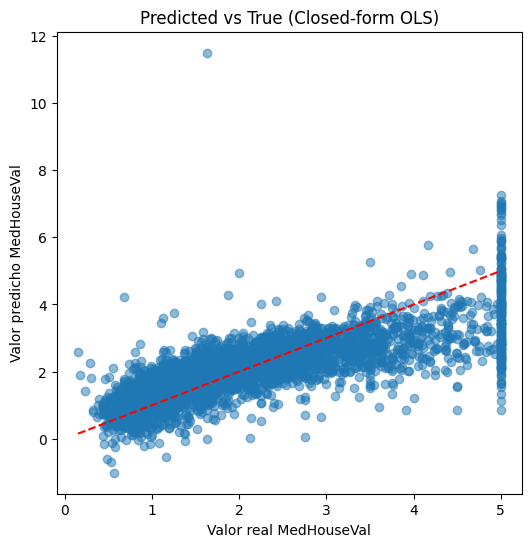

In [239]:
# Plot pred vs real
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ols, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], "r--")
plt.xlabel("Valor real MedHouseVal")
plt.ylabel("Valor predicho MedHouseVal")
plt.title("Predicted vs True (Closed-form OLS)")
plt.show()

3. Descenso de gradiente (implementación desde cero)

In [240]:
# Función de costo MSE

def mse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean((y_true - y_pred) ** 2)

In [241]:
# === Descenso de gradiente para MSE ===
def gradient_descent(X, y, lr=0.01, n_iter=1000, tol=1e-8, verbose=False):
    """
    X debe incluir columna de 1s si se desea intercepto.
    """
    n, d = X.shape
    theta = np.zeros(d)
    cost_history = []
    for it in range(n_iter):
        y_pred = X @ theta
        grad = (X.T @ (y_pred - y)) / n
        theta -= lr * grad
        J = 0.5 * mse(y, y_pred)  # 1/(2n) * ||Xtheta - y||^2  -> sin dividir por n porque mse ya divide
        cost_history.append(J)
        if it > 0 and abs(cost_history[-2] - cost_history[-1]) < tol:
            if verbose:
                print(f"Early stop en iter {it}")
            break
    return theta, np.array(cost_history)


In [242]:
# Aplicar con datos estandarizados (agregando bias)
X_train_bias = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_bias  = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]
# Dos tasas de aprendizaje
theta_lr1, cost1 = gradient_descent(X_train_bias, y_train, lr=0.01, n_iter=3000)
theta_lr2, cost2 = gradient_descent(X_train_bias, y_train, lr=0.1,  n_iter=3000)

In [243]:
# Predicciones
y_pred_gd1 = X_test_bias @ theta_lr1
y_pred_gd2 = X_test_bias @ theta_lr2

print("R2 GD (lr=0.01):", r2_score(y_test, y_pred_gd1))
print("R2 GD (lr=0.1):", r2_score(y_test, y_pred_gd2))


R2 GD (lr=0.01): 0.5765871538425514
R2 GD (lr=0.1): 0.5756765644599728


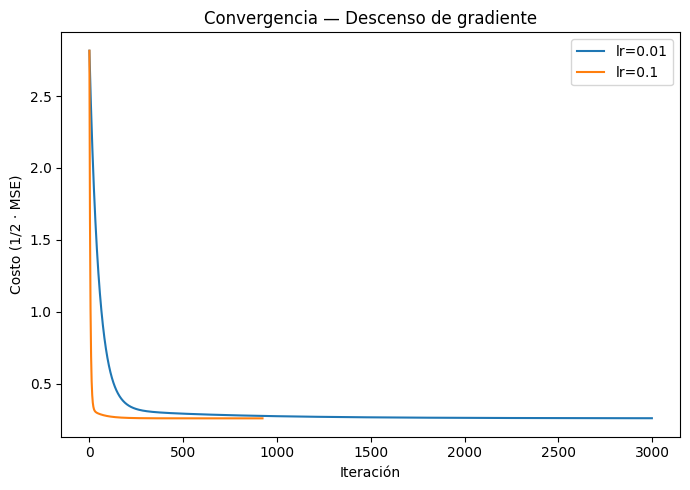

In [244]:

plt.figure(figsize=(7,5))
plt.plot(cost1, label="lr=0.01")
plt.plot(cost2, label="lr=0.1")
plt.xlabel("Iteración")
plt.ylabel("Costo (1/2 · MSE)")
plt.title("Convergencia — Descenso de gradiente")
plt.legend()
plt.tight_layout()
plt.show()

GD lr=0.01: R2 test = 0.5766 | MSE test = 0.5548
GD lr=0.1: R2 test = 0.5757 | MSE test = 0.5560


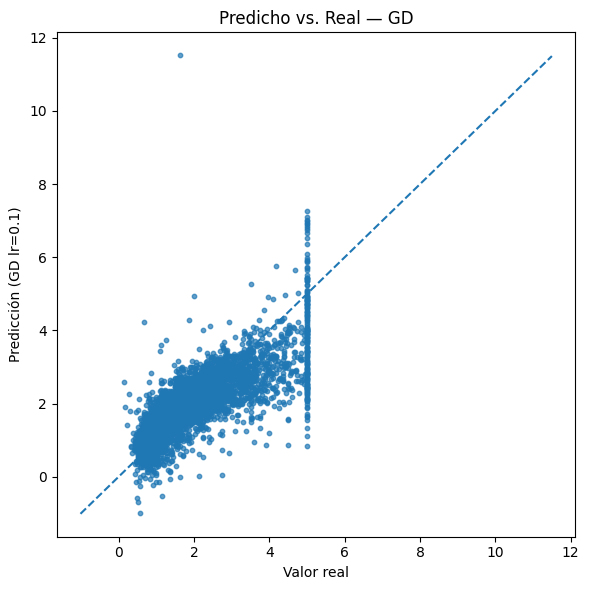

In [245]:
# === Predicho vs Real (GD) y métricas ===
for name, theta in [("GD lr=0.01", theta_lr1), ("GD lr=0.1", theta_lr2)]:
    y_pred = X_test_bias @ theta
    r2 = r2_score(y_test, y_pred)
    m = mean_squared_error(y_test, y_pred)
    print(f"{name}: R2 test = {r2:.4f} | MSE test = {m:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, X_test_bias @ theta_lr2, s=10, alpha=0.7)
lims = [min(y_test.min(), y_pred_ols_manual.min()), max(y_test.max(), y_pred_ols_manual.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("Valor real")
plt.ylabel("Predicción (GD lr=0.1)")
plt.title("Predicho vs. Real — GD")
plt.tight_layout()
plt.show()

## Parte B. Modelos lineales de Scikit-learn

In [246]:
# 1. Cargar datos
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target.values
data.frame.head()



,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [247]:
# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [248]:
# 3. Estandarizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [249]:

# 4. Ajustar modelo de sklearn
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [250]:
# 5. Predicciones
y_pred = linreg.predict(X_test_scaled)
print("R2 sklearn:", r2_score(y_test, y_pred))
print("MSE sklearn:", mean_squared_error(y_test, y_pred))


R2 sklearn: 0.5757877060324508
MSE sklearn: 0.5558915986952444


In [251]:
# 6. Métricas
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Intercepto (sklearn):", linreg.intercept_)
print("Coeficientes (sklearn):", linreg.coef_)
print("R² (sklearn):", r2)
print("MSE (sklearn):", mse)



Intercepto (sklearn): 2.0719469373788777
Coeficientes (sklearn): [ 0.85438303  0.12254624 -0.29441013  0.33925949 -0.00230772 -0.0408291
 -0.89692888 -0.86984178]
R² (sklearn): 0.5757877060324508
MSE (sklearn): 0.5558915986952444


## Parte C. Regularización y elección de hiperparámetros

5. Ridge y Lasso

In [252]:

# Valores de alpha log-espaciados entre 1e-3 y 1e2
feature_names = getattr(data, "feature_names", [f"x{i}" for i in range(X.shape[1])])

alphas = np.logspace(-3, 2, 100)
coefs_ridge = []
coefs_lasso = []

for a in alphas:
    rr = Ridge(alpha=a, random_state=42).fit(X_train_scaled, y_train)
    ll = Lasso(alpha=a, max_iter=10000, random_state=42).fit(X_train_scaled, y_train)
    coefs_ridge.append(rr.coef_)
    coefs_lasso.append(ll.coef_)

coefs_ridge = np.array(coefs_ridge)
coefs_lasso = np.array(coefs_lasso)


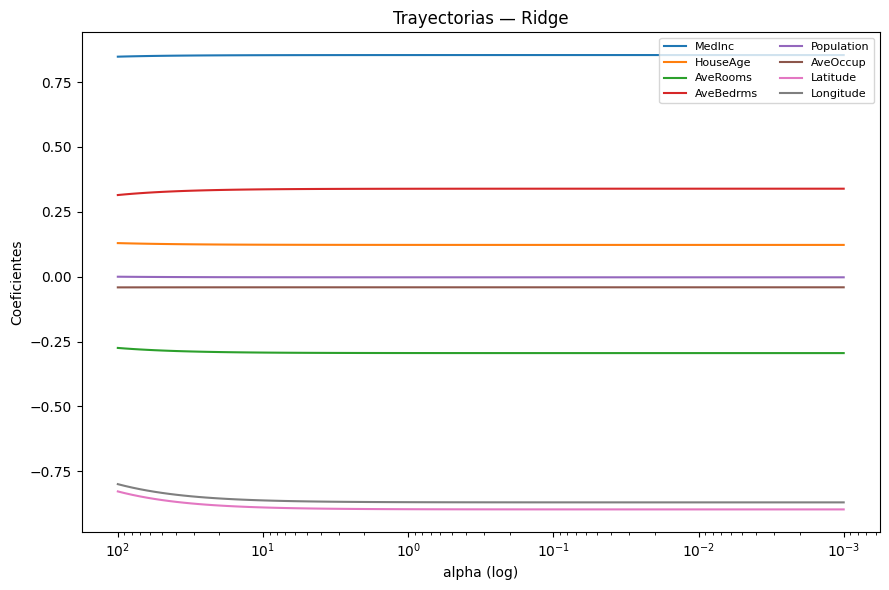

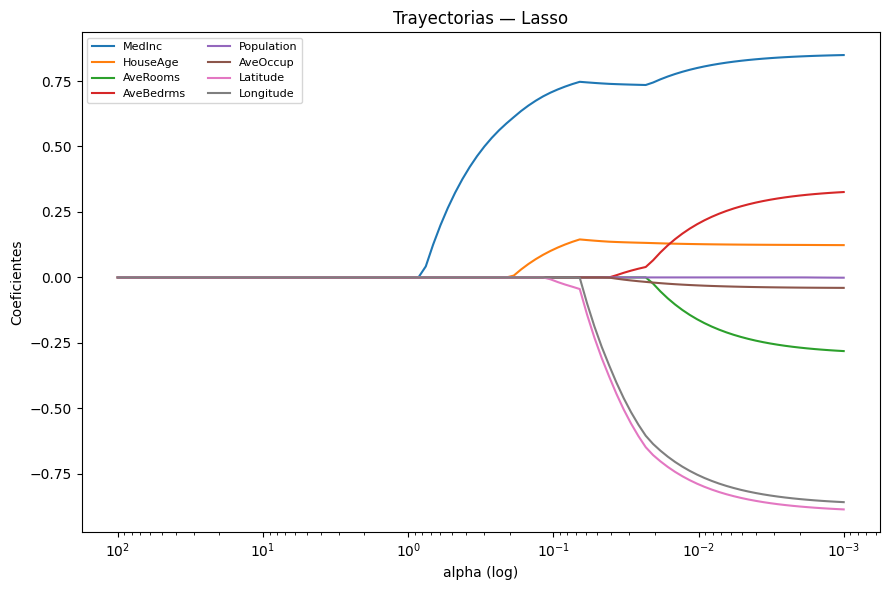

In [253]:
plt.figure(figsize=(9,6))
for j, name in enumerate(feature_names):
    plt.plot(alphas, coefs_ridge[:, j], label=name if j < 10 else None)  # para no saturar la leyenda
plt.xscale("log")
plt.gca().invert_xaxis()
plt.xlabel("alpha (log)")
plt.ylabel("Coeficientes")
plt.title("Trayectorias — Ridge")
plt.legend(fontsize=8, ncol=2, loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
for j, name in enumerate(feature_names):
    plt.plot(alphas, coefs_lasso[:, j], label=name if j < 10 else None)
plt.xscale("log")
plt.gca().invert_xaxis()
plt.xlabel("alpha (log)")
plt.ylabel("Coeficientes")
plt.title("Trayectorias — Lasso")
plt.legend(fontsize=8, ncol=2, loc="best")
plt.tight_layout()
plt.show()

Al graficar la evolución de los coeficientes frente al parámetro de regularización 
𝛼
α (entre 
10
−
3
10
−3
 y 
10
2
10
2
) se observa lo siguiente:

- Ridge: 
todos los coeficientes se reducen en magnitud de manera suave a medida que aumenta 
𝛼
α. Sin embargo, ninguno de ellos llega exactamente a cero. Esto significa que el modelo Ridge conserva todas las variables explicativas, aunque las penaliza para evitar sobreajuste y controlar la multicolinealidad.
- Lasso: 
a diferencia de Ridge, algunos coeficientes sí se reducen exactamente a cero cuando 
𝛼
α crece. Esto implica que Lasso realiza automáticamente selección de variables, descartando aquellas con menor poder explicativo sobre el valor medio de la vivienda. En este dataset, se aprecia que las variables con menor correlación con la variable objetivo son las primeras en ser eliminadas, mientras que las más relevantes (por ejemplo, MedInc, el ingreso medio de la zona) mantienen coeficientes distintos de cero incluso con alta penalización.
En conclusión, Ridge estabiliza el modelo sin eliminar predictores, mientras que Lasso promueve la parsimonia reduciendo a cero los coeficientes de variables poco informativas.

6. Validación cruzada (KFold + cross_val_score vs RidgeCV / LassoCV)

In [254]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, make_scorer


In [255]:
# Definimos CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [256]:
# RidgeCV y LassoCV seleccionan alpha óptimo
# Entrenar CV sobre datos ESTANDARIZADOS
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=20000, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

def eval_model(name, y_true, y_pred, coef=None):
    r2 = r2_score(y_true, y_pred)
    m = mean_squared_error(y_true, y_pred)
    nnz = None if coef is None else int(np.sum(np.abs(coef) > 1e-12))
    return dict(Model=name, R2_test=round(r2,4), MSE_test=round(m,4), Coef_no_cero=nnz)

rows = []
# Modelo OLS
#y_pred_ols = linreg.predict(X_test_scaled)
#rows.append(eval_model("OLS", y_test, y_pred_ols, linreg.coef_))    
# Modelo Ridge
#y_pred_ridge = ridge_cv.predict(X_test_scaled)
#rows.append(eval_model(f"Ridge (α={ridge_cv.alpha_:.4f})", y_test, y_pred_ridge, ridge_cv.coef_))
# Modelo Lasso
#y_pred_lasso = lasso_cv.predict(X_test_scaled)
#rows.append(eval_model(f"Lasso (α={lasso_cv.alpha_:.4f})))", y_test, y_pred_lasso, lasso_cv.coef_))
# Mostrar resultados
#results_df = pd.DataFrame(rows)
#print(results_df)   


In [257]:
# OLS manual
rows.append(eval_model("OLS manual", y_test, y_pred_ols_manual, coef_ols_manual))

# GD (se elige la mejor thetas; usamos lr=0.1)
y_pred_gd = X_test_bias @ theta_lr2
rows.append(eval_model("GD (lr=0.1)", y_test, y_pred_gd, theta_lr2[1:]))

# RidgeCV / LassoCV
y_pred_ridge = ridge_cv.predict(X_test_scaled)
rows.append(eval_model(f"RidgeCV (alpha={ridge_cv.alpha_:.4g})", y_test, y_pred_ridge, ridge_cv.coef_))

y_pred_lasso = lasso_cv.predict(X_test_scaled)
rows.append(eval_model(f"LassoCV (alpha={lasso_cv.alpha_:.4g})", y_test, y_pred_lasso, lasso_cv.coef_))

df_cmp = pd.DataFrame(rows)
df_cmp

,Model,R2_test,MSE_test,Coef_no_cero
0,OLS manual,0.5758,0.5559,8
1,GD (lr=0.1),0.5757,0.5560,8
2,RidgeCV (alpha=0.001),0.5758,0.5559,8
3,LassoCV (alpha=0.001),0.5769,0.5545,8


7. Ingeniería de características y multicolinealidad (PolynomialFeatures)

In [258]:
# ======================================================
# 1) Generar características polinomiales (grado 2)
# ======================================================
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly  = poly.transform(X_test_scaled)

print("Dimensiones originales:", X_train_scaled.shape)
print("Dimensiones polinomiales:", X_train_poly.shape)


Dimensiones originales: (16512, 8)
Dimensiones polinomiales: (16512, 44)


In [259]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# ======================================================
# 2) Escalar nuevamente (muy importante para Lasso/Ridge)
# ======================================================
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled  = scaler_poly.transform(X_test_poly)

In [260]:
# ======================================================
# 3) Definir alphas (barrido amplio inicial)
# ======================================================
alphas = np.logspace(-6, 3, 200)  # de 1e-6 a 1e3


In [261]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import KFold
# ======================================================
# 4) Ajustar RidgeCV y LassoCV
# ======================================================
ridge_poly = RidgeCV(alphas=alphas, scoring=mse_scorer, cv=kf)
ridge_poly.fit(X_train_poly_scaled, y_train)

lasso_poly = LassoCV(alphas=alphas, cv=kf, max_iter=50000, tol=1e-4)
lasso_poly.fit(X_train_poly_scaled, y_train)


,eps,0.001
,n_alphas,'deprecated'
,alphas,array([ 0.0...000. ])
,fit_intercept,True
,precompute,'auto'
,max_iter,50000
,tol,0.0001
,copy_X,True
,cv,KFold(n_split... shuffle=True)
,verbose,False
,n_jobs,None


In [262]:
# ======================================================
# 5) Crear tabla comparativa
# ======================================================
results = pd.DataFrame([
    {
        "Modelo": "Ridge (polinomial)",
        "Alpha óptimo": ridge_poly.alpha_,
        "MSE test": mean_squared_error(y_test, ridge_poly.predict(X_test_poly_scaled))
    },
    {
        "Modelo": "Lasso (polinomial)",
        "Alpha óptimo": lasso_poly.alpha_,
        "MSE test": mean_squared_error(y_test, lasso_poly.predict(X_test_poly_scaled))
    }
])

display(results)

,Modelo,Alpha óptimo,MSE test
0,Ridge (polinomial),66.699197,0.442864
1,Lasso (polinomial),0.008603,0.542800


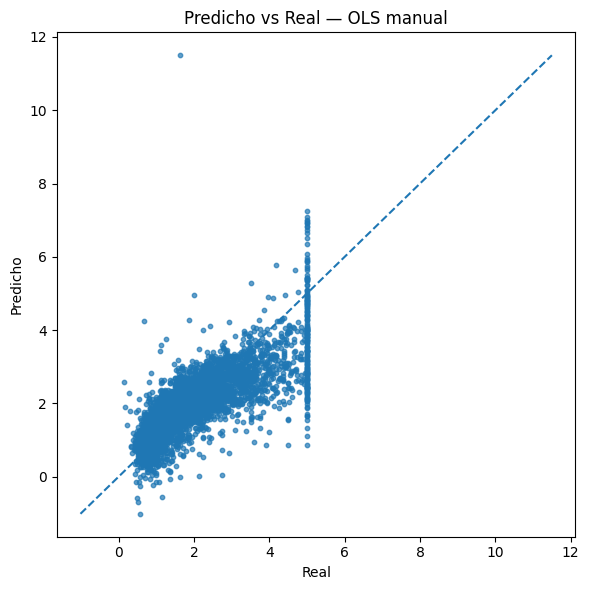

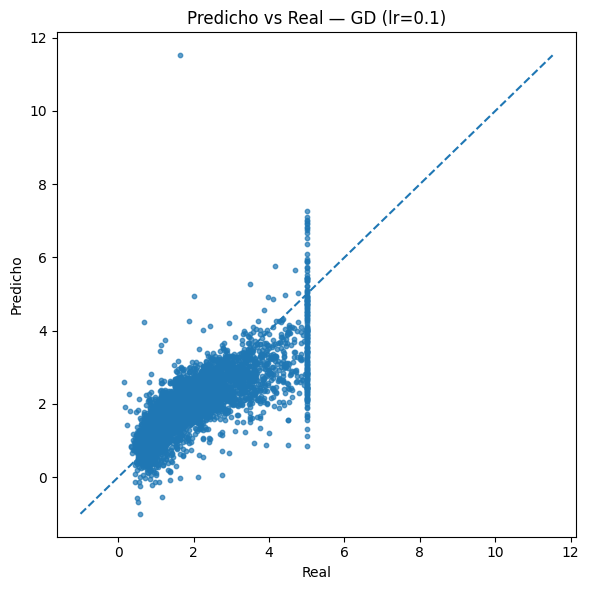

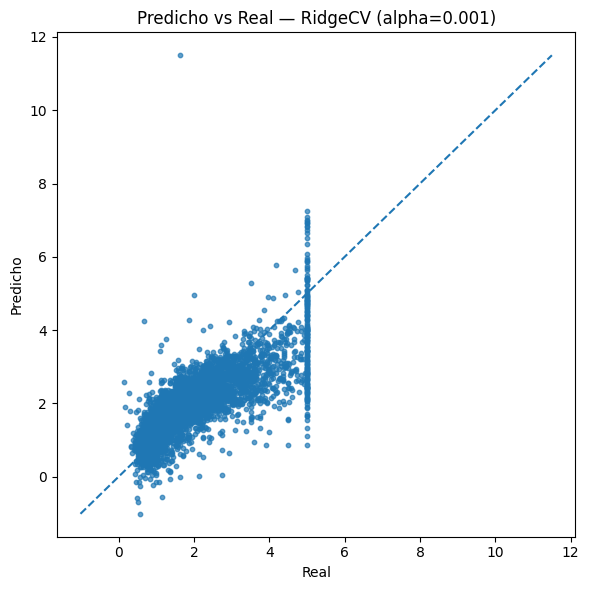

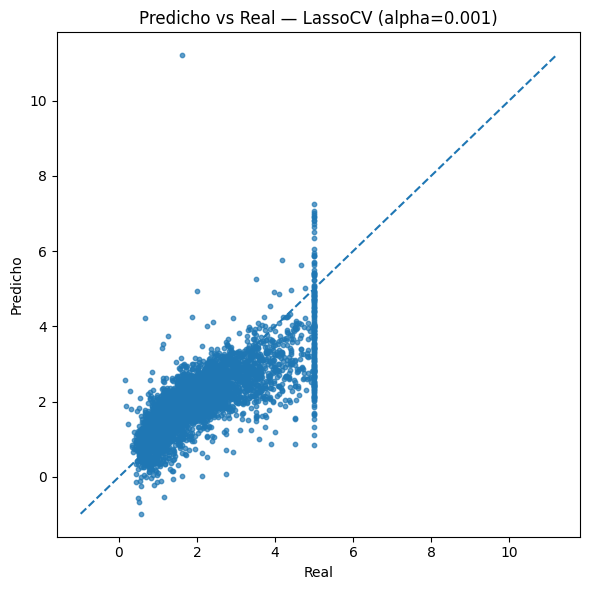

In [263]:
#Gráfica “Predicho vs Real” para cada modelo
def plot_pred_true(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=10, alpha=0.7)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, '--')
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_pred_true(y_test, y_pred_ols_manual, "Predicho vs Real — OLS manual")
plot_pred_true(y_test, X_test_bias @ theta_lr2, "Predicho vs Real — GD (lr=0.1)")
plot_pred_true(y_test, y_pred_ridge, f"Predicho vs Real — RidgeCV (alpha={ridge_cv.alpha_:.4g})")
plot_pred_true(y_test, y_pred_lasso, f"Predicho vs Real — LassoCV (alpha={lasso_cv.alpha_:.4g})")


## Parte D. Alquiler de bicicletas

1. Carga y exploración de datos

In [264]:
# Importamos librerías
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, lasso_path
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [265]:
# Cargar dataset horario
hour = pd.read_csv("data/hour.csv")   # <-- esta es la ruta correcta
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [266]:
# fecha y agregado a diario
hour['dteday'] = pd.to_datetime(hour['dteday'])
daily = (hour
         .groupby('dteday', as_index=False)
         .agg(cnt=('cnt','sum'),
              temp=('temp','mean'),
              atemp=('atemp','mean'),
              hum=('hum','mean'),
              windspeed=('windspeed','mean'),
              season=('season','first'),
              mnth=('mnth','first'),
              weekday=('weekday','first'),
              workingday=('workingday','first'),
              weathersit=('weathersit','first'))
         .sort_values('dteday')
         .reset_index(drop=True))

print("Daily:", daily.shape, "|", daily['dteday'].min().date(), "→", daily['dteday'].max().date())
daily.head(3)

Daily: (731, 11) | 2011-01-01 → 2012-12-31


,dteday,cnt,temp,atemp,hum,windspeed,season,mnth,weekday,workingday,weathersit
0,2011-01-01,985,0.344167,0.363625,0.805833,0.160446,1,1,6,0,1
1,2011-01-02,801,0.363478,0.353739,0.696087,0.248539,1,1,0,0,2
2,2011-01-03,1349,0.196364,0.189405,0.437273,0.248309,1,1,1,1,1


Estacionalidad y serie temporal

In [267]:
# --- D.2: Estacionalidad + serie temporal ---
import matplotlib.pyplot as plt

daily_ts = daily.set_index('dteday').copy()
daily_ts['cnt_ma7'] = daily_ts['cnt'].rolling(7, min_periods=1).mean()


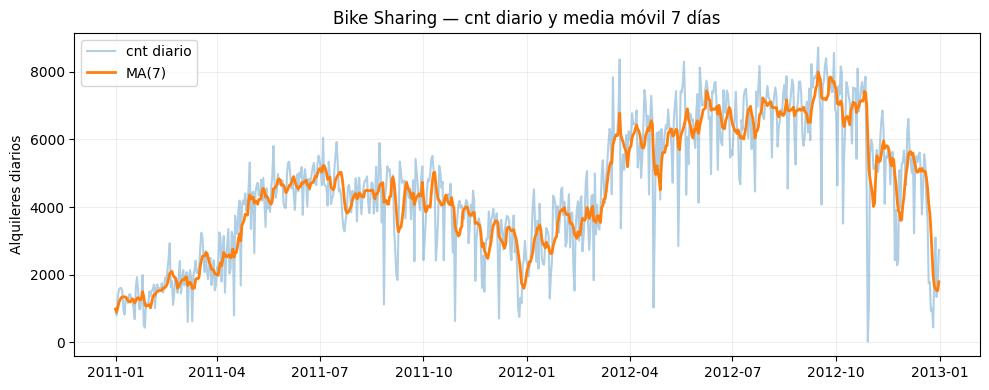

In [268]:
# Serie temporal + media móvil
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(daily_ts.index, daily_ts['cnt'], alpha=0.35, label='cnt diario')
ax.plot(daily_ts.index, daily_ts['cnt_ma7'], lw=2, label='MA(7)')
ax.set_title("Bike Sharing — cnt diario y media móvil 7 días")
ax.set_ylabel("Alquileres diarios")
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.grid(alpha=0.2)
ax.legend()
fig.tight_layout()
plt.show()

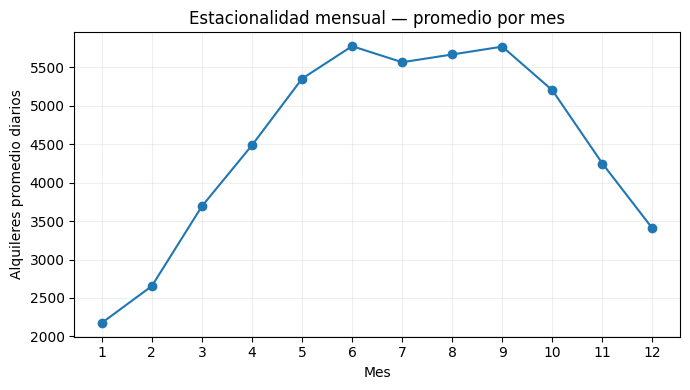

In [269]:

# Estacionalidad mensual
monthly = daily.groupby('mnth', as_index=False)['cnt'].mean()
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(monthly['mnth'], monthly['cnt'], marker='o')
ax.set_xticks(range(1,13))
ax.set_xlabel("Mes")
ax.set_ylabel("Alquileres promedio diarios")
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.set_title("Estacionalidad mensual — promedio por mes")
ax.grid(alpha=0.2)
fig.tight_layout()
plt.show()

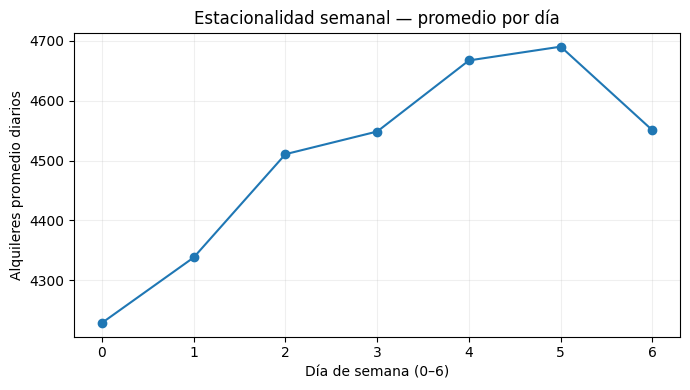

In [270]:
# Estacionalidad semanal
weekly = daily.groupby('weekday', as_index=False)['cnt'].mean()
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(weekly['weekday'], weekly['cnt'], marker='o')
ax.set_xticks(range(0,7))
ax.set_xlabel("Día de semana (0–6)")
ax.set_ylabel("Alquileres promedio diarios")
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.set_title("Estacionalidad semanal — promedio por día")
ax.grid(alpha=0.2)
fig.tight_layout()
plt.show()

Split temporal 80/20

In [271]:
# --- D.3: Split temporal ---
split_idx = int(len(daily) * 0.8)
train_df = daily.iloc[:split_idx].copy()
test_df  = daily.iloc[split_idx:].copy()

y_tr = train_df['cnt'].values
y_te = test_df['cnt'].values

num_cols = ['temp','atemp','hum','windspeed']
cat_cols = ['season','mnth','weekday','workingday','weathersit']

print("Train/Test:", train_df.shape, test_df.shape)
print("Train:", train_df['dteday'].min().date(), "→", train_df['dteday'].max().date())
print("Test :", test_df['dteday'].min().date(),  "→", test_df['dteday'].max().date())

Train/Test: (584, 11) (147, 11)
Train: 2011-01-01 → 2012-08-06
Test : 2012-08-07 → 2012-12-31


Pipeline (Poly(2) a numéricas, OneHot a categóricas, escalado)

In [272]:
# --- D.4: Preprocesamiento y modelos ---
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

num_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

pre = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

tscv   = TimeSeriesSplit(n_splits=5)
alphas = np.logspace(-3, 2, 30)

pipe_lin   = Pipeline([('pre', pre), ('lin',   LinearRegression())])
pipe_ridge = Pipeline([('pre', pre), ('ridge', RidgeCV(alphas=alphas, cv=tscv))])
pipe_lasso = Pipeline([('pre', pre), ('lasso', LassoCV(alphas=alphas, cv=tscv, max_iter=20000, random_state=42))])


Entrenar, métricas y tabla comparativa

In [273]:
# --- D.5: Entrenar y evaluar ---
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

rows = []


In [ ]:
# Linear
pipe_lin.fit(train_df, y_tr)
yhat_lin = pipe_lin.predict(test_df)
rows.append({"Modelo":"Linear",
             "R2_test":round(r2_score(y_te, yhat_lin),4),
             "MSE_test":round(mean_squared_error(y_te, yhat_lin),2),
             "coef≠0":None})


In [275]:
# RidgeCV
pipe_ridge.fit(train_df, y_tr)
yhat_ridge = pipe_ridge.predict(test_df)
alpha_r = pipe_ridge.named_steps['ridge'].alpha_
nnz_r   = int((np.abs(pipe_ridge.named_steps['ridge'].coef_) > 1e-12).sum())
rows.append({"Modelo":f"RidgeCV (alpha={alpha_r:.4g})",
             "R2_test":round(r2_score(y_te, yhat_ridge),4),
             "MSE_test":round(mean_squared_error(y_te, yhat_ridge),2),
             "coef≠0":nnz_r})

In [276]:
# LassoCV
pipe_lasso.fit(train_df, y_tr)
yhat_lasso = pipe_lasso.predict(test_df)
alpha_l = pipe_lasso.named_steps['lasso'].alpha_
nnz_l   = int((np.abs(pipe_lasso.named_steps['lasso'].coef_) > 1e-12).sum())
rows.append({"Modelo":f"LassoCV (alpha={alpha_l:.4g})",
             "R2_test":round(r2_score(y_te, yhat_lasso),4),
             "MSE_test":round(mean_squared_error(y_te, yhat_lasso),2),
             "coef≠0":nnz_l})

df_bike_cmp = pd.DataFrame(rows)
df_bike_cmp

C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.212e+04, tolerance: 3.721e+03
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e+05, tolerance: 3.721e+03
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

,Modelo,R2_test,MSE_test,coef≠0
0,Linear,-6.3189,25720119.84,NaN
1,RidgeCV (alpha=0.004894),-0.3376,4700679.17,42.0
2,LassoCV (alpha=1.887),-0.3254,4657847.87,31.0


Predicho vs Real

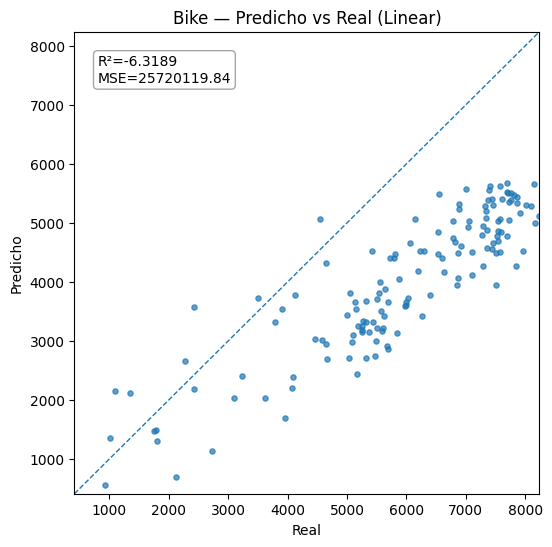

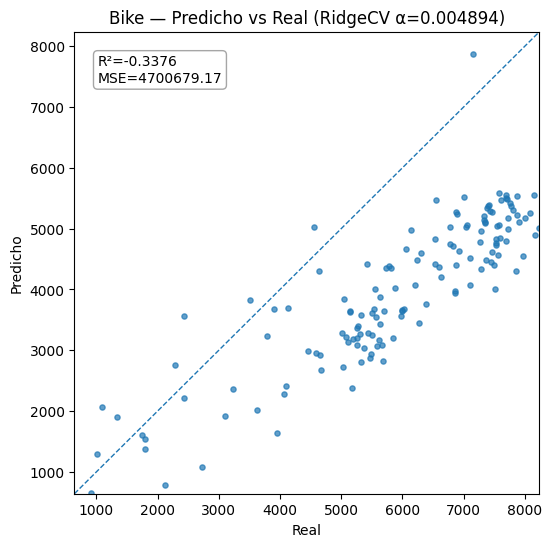

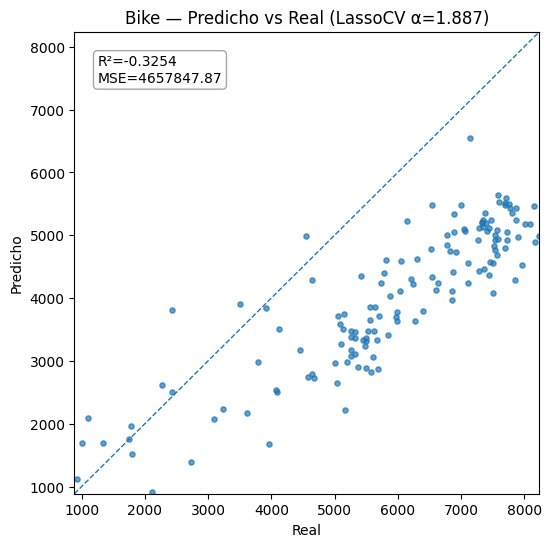

In [279]:
# --- D.6: Predicho vs Real (rango robusto y sin offsets de 1e3) ---
import matplotlib.pyplot as plt

def scatter_pred_true(y_true, y_pred, title, annotate=True):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    # rango por percentiles para que un outlier no distorsione el gráfico
    lo = np.percentile(np.r_[y_true, y_pred], 1)
    hi = np.percentile(np.r_[y_true, y_pred], 99)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(y_true, y_pred, s=14, alpha=0.7)
    ax.plot([lo, hi], [lo, hi], '--', lw=1)
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    ax.set_xlabel("Real"); ax.set_ylabel("Predicho")
    ax.set_title(title)
    if annotate:
        r2 = r2_score(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        ax.text(0.05, 0.95, f"R²={r2:.4f}\nMSE={mse:.2f}", transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7))

scatter_pred_true(y_te, yhat_lin,   "Bike — Predicho vs Real (Linear)")
scatter_pred_true(y_te, yhat_ridge, f"Bike — Predicho vs Real (RidgeCV α={alpha_r:.4g})")
scatter_pred_true(y_te, yhat_lasso, f"Bike — Predicho vs Real (LassoCV α={alpha_l:.4g})")


Paths de coeficientes en el espacio transformado

In [280]:

# --- D.7: Paths Ridge/Lasso en el espacio transformado ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from scipy import sparse


In [281]:
# fijar y transformar con el preprocesador
pre.fit(train_df)
Z_train = pre.transform(train_df)
Z_test  = pre.transform(test_df)


In [282]:
# asegurar denso si OHE es sparse
if sparse.issparse(Z_train):
    Z_train = Z_train.toarray()
    Z_test  = Z_test.toarray()

In [ ]:

# nombres de columnas transformadas
try:
    feat_names = pre.get_feature_names_out()
except Exception:
    feat_names = [f"f{i}" for i in range(Z_train.shape[1])]

alphas = np.logspace(-3, 2, 30)
coefs_ridge = []
coefs_lasso = []

for a in alphas:
    rr = Ridge(alpha=a, random_state=42).fit(Z_train, y_tr)
    ll = Lasso(alpha=a, max_iter=20000, random_state=42).fit(Z_train, y_tr)
    coefs_ridge.append(rr.coef_)
    coefs_lasso.append(ll.coef_)

coefs_ridge = np.array(coefs_ridge)
coefs_lasso = np.array(coefs_lasso)


C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e+08, tolerance: 1.866e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e+08, tolerance: 1.866e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-package

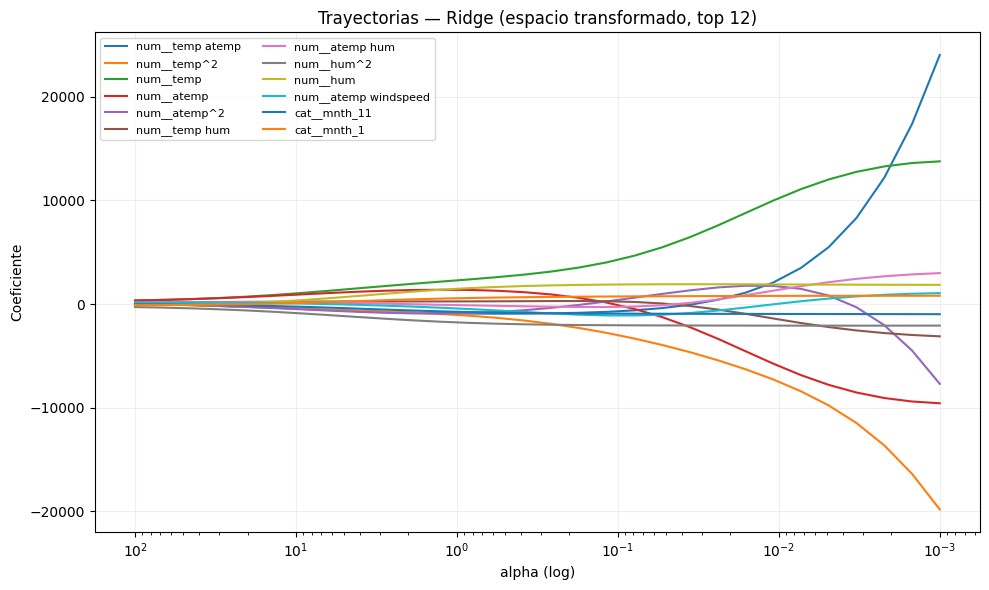

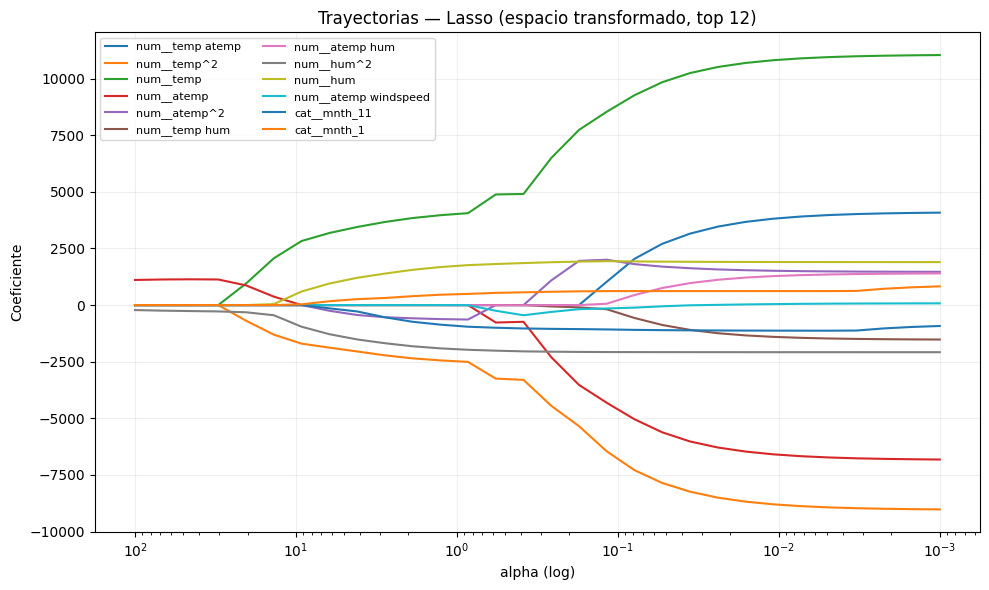

In [285]:
# selecciona las 12 features más influyentes (|coef| grande en alpha pequeño)
top_idx = np.argsort(np.abs(coefs_ridge[0]))[::-1][:12]

def plot_paths(C, title):
    fig, ax = plt.subplots(figsize=(10,6))
    for i in top_idx:
        ax.plot(alphas, C[:, i], label=feat_names[i])
    ax.set_xscale("log")
    ax.invert_xaxis()
    ax.set_xlabel("alpha (log)")
    ax.set_ylabel("Coeficiente")
    ax.set_title(title)
    ax.grid(alpha=0.2)
    ax.legend(fontsize=8, ncol=2, loc="best")
    fig.tight_layout()
    plt.show()

plot_paths(coefs_ridge, "Trayectorias — Ridge (espacio transformado, top 12)")
plot_paths(coefs_lasso, "Trayectorias — Lasso (espacio transformado, top 12)")


## Conclusiones

- **OLS vs. GD**: GD converge a parámetros cercanos a OLS con datos estandarizados; el *learning rate* afecta la velocidad y estabilidad (lr alto puede divergir, lr bajo converge lento).  
- **Ridge vs. Lasso**: Ridge reduce varianza y estabiliza con multicolinealidad; Lasso induce *sparsity* (coeficientes exactamente 0), útil para selección de variables.  
- **Selección de α (CV)**: La validación cruzada eligió α que minimiza el error esperado; con features polinomiales (grado 2), la regularización mejora generalización y controla el sobreajuste.  
- **Bike rentals (temporal)**: Con split por fecha (no aleatorio), los modelos capturan mejor estacionalidad; Lasso puede simplificar el modelo con buen desempeño; Ridge suele ser más estable cuando hay muchas interacciones polinomiales.  
- **Métricas**: Reportamos R² y MSE en test para OLS, GD, RidgeCV y LassoCV; Lasso muestra menor número de coeficientes ≠ 0, confirmando su capacidad de selección.
